In [1]:
import numpy as np
from numpy import sqrt
from numpy import cross
from numpy import power as pow
from numpy import dot
from numpy import arccos as acos
from numpy import sin
from numpy import cos
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from scipy.integrate import quad
import scipy
from sympy.solvers import solve
from sympy import Symbol
import sympy
import timeit
import multiprocessing as mp
from scipy.spatial.transform import Rotation
from tqdm import tqdm
from tqdm import trange
from time import sleep

In [2]:
def length(v):
    return sqrt(dot(v, v))

In [58]:
# Setup
bh_mass = 1

integrate_end = 2000

disk_inner = 2
disk_outer = 10

camera_pos = np.array([0,1,15])
r0 = length(camera_pos)
bh_pos = np.array([0,0,0])

texture_path = "starfield/"



new_row = 4 * 256
new_col = 4 * 256
new_size = np.array([new_row, new_col, 3])
sample_count = 16
tex_size = 4096
total_process = 8

In [59]:
rs = 2 * bh_mass

In [60]:
front = mpimg.imread(texture_path + "front.jpg")/255
back = mpimg.imread(texture_path + "back.jpg")/255
right = mpimg.imread(texture_path + "right.jpg")/255
left = mpimg.imread(texture_path + "left.jpg")/255
top = mpimg.imread(texture_path + "top.jpg")/255
bottom = mpimg.imread(texture_path + "bottom.jpg")/255

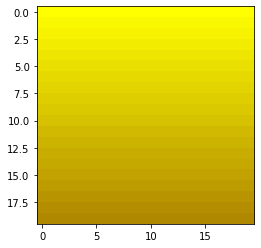

In [63]:
disk_resolution = 20
disk_tex = np.zeros([disk_resolution,disk_resolution,3], dtype=np.float32)

for row in range(disk_resolution):
    color = random.randrange(95,100)/100
    for col in range(disk_resolution):
        disk_tex[row][col] = [1-((row)/3/disk_resolution) *color, 1-((row)/2/disk_resolution)  * color , 0]
plt.imshow(disk_tex)

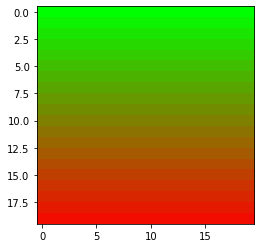

In [31]:
disk_resolution = 20
disk_tex = np.zeros([disk_resolution,disk_resolution,3], dtype=np.float32)

for row in range(disk_resolution):
    for col in range(disk_resolution):
        disk_tex[row][col] = [row/disk_resolution, 1-(row/disk_resolution), 0]
plt.imshow(disk_tex)

In [25]:
def CalculateImpactParameter(theta, r, rs):
    return r * np.sin(theta) / np.sqrt(1 - rs / r)

In [26]:
def Geodesic(r, b):
    return 1 / (pow(r, 2) * sqrt(pow(1 / b, 2) - pow(1 / r, 2) + rs / pow(r, 3)))

In [27]:
def Integrate(x0, x1, b, h):
    y = 0
    while x0 < x1:
        k1 = Geodesic(x0, b)
        k2 = Geodesic(x0 + k1*h/2, b)
        k3 = Geodesic(x0 + k2*h/2, b)
        k4 = Geodesic(x0 + k3*h, b)
        y = y + (k1 + 2*k2 + 2*k3 + k4) * h / 6
        x0 = x0 + h
    return y

In [28]:
def Integrate(start, end, b):
    return quad(Geodesic, start, end, args=(b,))[0]

In [29]:
def normalize(v):
    return v / length(v)

In [30]:
def SkyboxSampler(tex_coord):
    if abs(tex_coord[0]) == abs(tex_coord[1]) == abs(tex_coord[2]):
        side_index = 2
    else:
        side_index = np.where(tex_coord == max(tex_coord, key=abs))[0][0]

    if tex_coord[side_index] < 0:
        scale = -1 / tex_coord[side_index]
        tex_coord = tex_coord * scale
    elif tex_coord[side_index] > 0:
        scale = 1 / tex_coord[side_index]
        tex_coord = tex_coord * scale
    # print("scaled tex_coord:", tex_coord)
    # print("side index: ", side_index)

    if side_index == 2:
        if tex_coord[side_index] > 0:
            image = back
        elif tex_coord[side_index] < 0:
            image = front
        coord_2d = (tex_coord[0:2] + 1) / 2
    elif side_index == 1:
        if tex_coord[side_index] > 0:
            image = top
        elif tex_coord[side_index] < 0:
            image = bottom
        coord_2d = (tex_coord[0:3:2] + 1) / 2
    elif side_index == 0:
        if tex_coord[side_index] > 0:
            image = right
        elif tex_coord[side_index] < 0:
            image = left
        coord_2d = (tex_coord[1:3] + 1) / 2
    color = np.zeros([3], dtype=np.float32)
    row = int(np.rint((1 - coord_2d[1]) * (tex_size - 1)))
    col = int(np.rint(coord_2d[0] * (tex_size - 1)))
    color = image[row][col]
    return color

In [31]:
def GetTexCoord(row, col):
    z = -1
    x = col / (new_col - 1) * (1 - (-1)) -1
    y = (new_row - row - 1) / (new_row - 1) * (1 - (-1)) -1
    return np.array([x, y, z])

In [32]:
def GetCosAngle(v1, v2):
    return dot(v1, v2) / (length(v1) * length(v2))

In [33]:
def FindClosestApproach(r0, b):
    return scipy.optimize.root(lambda r: r/sqrt(1 - 2/r) - b, r0).x[0]

In [34]:
def RotationMatrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / sqrt(np.dot(axis, axis))
    a = cos(theta / 2.0)
    b, c, d = -axis * sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])


In [35]:
def Trace(tex_coord):
    bh_dir = bh_pos - camera_pos
    cos_theta = GetCosAngle(tex_coord, bh_dir)
    theta = acos(cos_theta)
    b = CalculateImpactParameter(theta, r0, rs)
    if b < sqrt(27):
        return [0,0,0]
    else:
        r3 = FindClosestApproach(r0, b)
        dphi = np.fmod(quad(Geodesic, r0, r3, args=(b,))[0] - quad(Geodesic, r3, integrate_end, args=(b,))[0], np.pi*2)
        distort_coord = np.dot(RotationMatrix(cross(tex_coord, bh_dir), dphi), bh_dir / r0)
        return SkyboxSampler(distort_coord)

In [36]:
# photon_pos(r, phi, theta) is in spherical coordinates
def CheckDiskHit(photon_pos):
    if photon_pos.x > disk_inner and photon_pos.x > disk_outer:
        return False
    if photon_pos.z > np.pi/2 - 0.01 and photon_pos.z < np.pi/2 + 0.01:
        return True
    return False

In [37]:
def RenderWorker(pid):
    new_img = np.zeros(new_size, dtype=np.float32)
    if pid == 0:
        for row in trange(pid, new_row, total_process):
            for col in range(0, new_col):
                tex_coord = GetTexCoord(row, col)
                new_img[row][col] = Trace(tex_coord)
    else:
        for row in range(pid, new_row, total_process):
            for col in range(0, new_col):
                tex_coord = GetTexCoord(row, col)
                new_img[row][col] = Trace(tex_coord)

    return new_img

In [38]:
# start_pos has length of disk_inner or disk_outer
def DiskSampler(start_pos, b, r0, r1, rotation_axis):
    total_dphi = Integrate(r0, r1, b)

    direction = 0
    if r0 < r1:
        direction = 1
    else:
        direction = -1

    start_pos = start_pos / length(start_pos) * r0

    disk_span = disk_outer - disk_inner
    step_size = 0.1
    pos_near_disk = start_pos
    pos = start_pos
    integrate_span = abs(r0 - r1)
    steps = int(integrate_span / step_size)
    for step in range(1, steps + 1):
        last_pos = pos
        if abs(pos[1]) < abs(pos_near_disk[1]):  # closer to the disk
            pos_near_disk = pos
        dphi = Integrate(r0, r0 + step * step_size * direction, b)
        pos = Rotation.from_rotvec(abs(dphi) * rotation_axis).apply(start_pos)
        pos = pos / length(pos) * (r0 + step * step_size * direction)
        if np.sign(pos[1]) != np.sign(last_pos[1]):
            break        
    dr = length(pos_near_disk) - disk_inner


    sample_index = int(dr / disk_span * (disk_resolution - 1))

    # print(sample_index)
    return disk_tex[sample_index][0]

In [39]:
def Trace(tex_coord):
    bh_dir = bh_pos - camera_pos
    rotation_axis = normalize(cross(tex_coord, bh_dir))
    cos_theta = GetCosAngle(tex_coord, bh_dir)
    theta = acos(cos_theta)
    b = CalculateImpactParameter(theta, r0, rs)
    if b < sqrt(27):
        dphi = np.fmod(quad(Geodesic, r0, disk_outer, args=(b,))[0], np.pi*2)
        # photon position when entering accretion disk region
        photon_pos_start = Rotation.from_rotvec(-dphi * rotation_axis).apply(camera_pos)
        dphi_in_disk = quad(Geodesic, disk_outer, disk_inner, args=(b,))[0]
        if abs(dphi_in_disk) > np.pi:
            return DiskSampler(photon_pos_start, b, disk_outer, disk_inner, rotation_axis)
            # return [0,0,1]
        dphi = np.fmod(dphi + dphi_in_disk, np.pi*2)
        # photon position when leaving accretion disk region
        photon_pos_end = Rotation.from_rotvec(-dphi * rotation_axis).apply(camera_pos)

        if np.sign(photon_pos_start[1]) != np.sign(photon_pos_end[1]):
            return DiskSampler(photon_pos_start, b, disk_outer, disk_inner, rotation_axis)
            # return [0,0,1]
        # print("tex coord: ", tex_coord)
        return [0,0,0]
    else:
        r3 = FindClosestApproach(r0, b)
        if r3 > disk_outer:
            dphi = np.fmod(Integrate(r0, r3, b) - Integrate(r3, integrate_end, b), np.pi*2)
            distort_coord = Rotation.from_rotvec(-dphi * rotation_axis).apply(camera_pos)
            return SkyboxSampler(distort_coord)
        else:   # r3 < disk_outer, possible hit
            # photon position when entering accretion disk region
            dphi = np.fmod(quad(Geodesic, r0, disk_outer, args=(b,))[0], np.pi*2)
            #photon_pos_start = np.dot(RotationMatrix(rotation_axis, -dphi), camera_pos)
            photon_pos_start = Rotation.from_rotvec(-dphi * rotation_axis).apply(camera_pos)
        

            if r3 < disk_inner: # incomplete!
                # photon position when leaving accretion disk region
                dphi_in_disk = quad(Geodesic, disk_outer, disk_inner, args=(b,))[0]
                dphi = np.fmod(dphi + dphi_in_disk, np.pi*2)
                photon_pos_end = Rotation.from_rotvec(-dphi * rotation_axis).apply(camera_pos)
                if np.sign(photon_pos_start[1]) != np.sign(photon_pos_end[1]): # hit?
                    return DiskSampler(photon_pos_start, b, disk_outer, disk_inner, rotation_axis)
                else:   # not hit
                    dphi = np.fmod(dphi + Integrate(disk_inner, r3, b), np.pi*2)    # inner -> r3
                    dphi = np.fmod(dphi - Integrate(r3, integrate_end, b), np.pi*2)  # r3 -> skybox
                    distort_coord = Rotation.from_rotvec(-dphi * rotation_axis).apply(camera_pos)
                    return SkyboxSampler(distort_coord)
            else:   # r3 > disk_inner
                # photon position when leaving accretion disk region
                dphi_in_disk = quad(Geodesic, disk_outer, r3, args=(b,))[0]
                dphi = np.fmod(dphi + dphi_in_disk, np.pi*2)
                photon_pos_end = Rotation.from_rotvec(-dphi * rotation_axis).apply(camera_pos)
                if np.sign(photon_pos_start[1]) != np.sign(photon_pos_end[1]): # hit?
                    return DiskSampler(photon_pos_start, b, disk_outer, r3, rotation_axis)
                    # return [0,0,1]
                photon_pos_start = photon_pos_end   # at r3
                dphi_in_disk = quad(Geodesic, r3, disk_outer, args=(b,))[0]
                dphi = np.fmod(dphi - dphi_in_disk, np.pi*2)
                photon_pos_end = Rotation.from_rotvec(-dphi * rotation_axis).apply(camera_pos)
                if np.sign(photon_pos_start[1]) != np.sign(photon_pos_end[1]): # hit?
                    ####### Debug #######
                        # if tex_coord[1] < -0.2 and abs(tex_coord[0]) < 0.05 :
                        #     return DiskSampler(photon_pos_start, b, r3, disk_outer, rotation_axis)
                        # else:
                        #     return [0,0,1]
                    ####################
                    return DiskSampler(photon_pos_start, b, r3, disk_outer, rotation_axis)
                    # return [0,0,1]
                
                # not hit
                dphi = np.fmod(dphi - quad(Geodesic, disk_outer, integrate_end, args=(b,))[0], np.pi*2)
                distort_coord = Rotation.from_rotvec(-dphi * rotation_axis).apply(camera_pos)
                return SkyboxSampler(distort_coord)

100%|██████████| 128/128 [1:07:54<00:00, 31.83s/it]
CPU times: user 491 ms, sys: 326 ms, total: 817 ms
Wall time: 1h 8min 3s


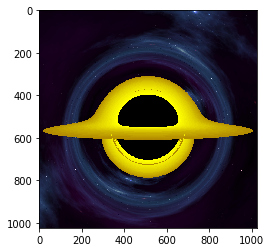

In [64]:
%%time
new_img = np.zeros(new_size, dtype=np.float32)

pool = mp.Pool(processes=total_process)
data = pool.map(RenderWorker, range(total_process))

new_img = sum(data)
plt.imshow(new_img)

In [ ]:
def Render():
    for row in trange(0, new_row):
        for col in range(0, new_col):
            tex_coord = GetTexCoord(row, col)
            new_img[row][col] = Trace(tex_coord)

In [ ]:
%%time
# single thread
new_img = np.zeros(new_size, dtype=np.float32)
Render()
plt.imshow(new_img)

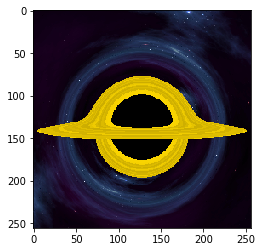

In [55]:
plt.imshow(new_img)

In [56]:
plt.imsave("4-8-1.png", new_img)

In [ ]:
Integrate(12, 200, b, 0.01)

In [ ]:
quad(Geodesic, 20, 200000, args=(b,))

In [ ]:
FindClosestApproach(20, 10)

In [ ]:
Rotation.from_rotvec(np.pi/2 * np.array([1,0,0])).apply(v)

In [ ]:
photon_pos_start = Rotation.from_rotvec(dphi * rotation_axis).apply(camera_pos)

In [ ]:
from tqdm import trange

for i in trange(100):
    sleep(0.01)

In [ ]:
for i in range(5):
    print(i)
    sleep(0.25)

In [ ]:
test = np.array([1,2,3])

In [ ]:
np.array([1,2,3])/length(test) * 3

In [ ]:
length([-3.53261166 , 0.04886885 , 9.35511981])